## Proyecto 1

Empezamos importando nuestras librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

Creamos la funcipón para la carga de datos. Aquí creamos nuestro dataframe, mezclamos su contenido y separamos nuestros datasets de entranamiento y y pruebas.

In [2]:
def cargaDatos():
    df = pd.DataFrame(np.load('proyecto_training_data.npy'), columns= ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
    df= df.sample(frac=1, ignore_index=True)
    filas = len(df)
    slicing = int(filas*0.8)
    df_entre = df[:slicing]
    df_prueba = df[slicing:]

    return df, df_entre, df_prueba

Creamos una clase para nuestros nuevos dataframes y los almacenamos en un objeto para seguir trabajando con la misma data durante todo el desarrollo del programa

In [3]:
class dataframes:
    def __init__(self, df, df_entre, df_prueba):
        self.df = df
        self.df_entre = df_entre
        self.df_prueba = df_prueba

df, df_entre, df_prueba = cargaDatos()

data = dataframes(df, df_entre, df_prueba)


Creamos la función para el análisis exploratorio de datos

In [4]:
def analisis():
    analisisExp = data.df_entre
    analisisExp = analisisExp.describe().loc[['mean','max', 'min', 'std'],:] # extraemos las columnas deseadas
    analisisExp = analisisExp.rename(index={'mean': 'Media','max':'Máximo', 'min':'Mínimo', 'std': 'Desviación estándar'})

    rango = pd.DataFrame({ #generamos los rangos restando los máximos y mínimos
            'SalePrice': [analisisExp['SalePrice'].max() - analisisExp['SalePrice'].min()],
            'OverallQual': [analisisExp['OverallQual'].max() - analisisExp['OverallQual'].min()],
            '1stFlrSF': [analisisExp['1stFlrSF'].max() - analisisExp['1stFlrSF'].min()],
            'TotRmsAbvGrd': [analisisExp['TotRmsAbvGrd'].max() - analisisExp['TotRmsAbvGrd'].min()],
            'YearBuilt': [analisisExp['YearBuilt'].max() - analisisExp['YearBuilt'].min()],
            'LotFrontage': [analisisExp['LotFrontage'].max() - analisisExp['LotFrontage'].min()]},
            index= ['Rango'])

    analisisExp = pd.concat([analisisExp, rango])
    analisisExp = analisisExp.loc[['Media','Máximo', 'Mínimo', 'Rango', 'Desviación estándar'],:] #cambiamos el orden de las columnas
    return analisisExp


Función para generar histogramas

In [5]:
def histogramas():
    for columna in data.df_entre.columns:
        sb.histplot(data.df_entre[columna], color='green').set(title=f'Histograma de {columna}', xlabel=columna, ylabel='Frecuencia')
        plt.show()

Función para calcular la correlación entre variables

In [6]:
def correlacion():
    corr = data.df_entre.corr() #correlacion
    mask = np.zeros_like(corr, dtype=bool) #mascara para ocultar los datos duplicados en el mapa de calor
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(9, 7))
    sb.heatmap(corr, annot=True, cmap='Greens', mask=mask, vmax=0.8, vmin=0, square=True, linewidths=.8).set_title('Correlación entre columnas')
    plt.show()

Función para graficar la disperción de las variables

In [7]:
def scatterplot():
    cols = data.df_entre.columns
    for i, a in enumerate(cols): #iteración de columna a
        for j, b in enumerate(cols): #iteración de columna b
            if i >= j: #condición para evitar gráficas duplicadas
                continue
            x = data.df_entre[a]
            y = data.df_entre[b]
            corr = round(x.corr(y), 2)
            title = f'Scatterplot de {a} vs {b} (Correlación: {corr})'

            plt.figure()
            plt.scatter(x, y, c='green', s=10,marker='.')
            plt.title(title)
            plt.xlabel(a)
            plt.ylabel(b)
            plt.show()

Elegimos nuestras variables independientes 'OverallQual' y '1stFlrSF' y como variable dependiente 'SalePrice', ya que son las que más correlación tienen con el precio de venta. Lo cuál es lógico porque el precio de venta puede cambiar por la calificación que le den a la casa y el metraje de la misma.

#### Función para el modelo de regresión linean

In [137]:
def modelo(x, y, epochs:int, imprimir_error_cada:int, rate:float):
    # Creamos la matriz x1 con una columna con el vector x otra llena de 1s
    x1 = np.hstack((x.reshape(-1, 1), np.ones_like(x.reshape(-1, 1))))
    
    # Inicializamos en 0 los parámetros donde betas = [b1, b0]
    betas = np.zeros((2,1))
    n = len(y)

    # Creamos una lista vacía para almacenar el error en cada iteración
    error = []

    # Creamos listas para almacenar yPrima y el número de iteración
    index = []
    yPrima = []
    
    for i in range(epochs):
        # Calculamos las predicciones del modelo para todos los datos
        y1 = np.dot(x1, betas)
        yPrima.append(y1)

        # Calculamos el error cuadrádito medio entre las predicciones y los valores reales
        costo = np.sum((y.reshape(-1,1) - y1) ** 2) / (2 * n)
        
        # Almacenamos el error en la lista
        error.append(costo)
        
        # Imprimimos el error con el número de iteración
        if (i+1) % imprimir_error_cada == 0:
            print(f"El error en el epoch {i+1} es de {costo}")
        
        # Obtenemos los gradientes donde gradiente = [gb1, gb0]
        gradientes = np.dot(x1.T, (y1 - y.reshape(-1, 1))) / n

        # Actualizamos b1 y b0
        betas = betas - np.dot(gradientes, rate)
        index.append(i)
        
    # Devolvemos los valores resultantes y error por cada iteración
    return index, error, yPrima

In [ ]:
index, error, yPrima = modelo(df_entre['OverallQual'].values, df_entre['SalePrice'].values, 1500, 150, 0.0001)

In [ ]:
index, error, yPrima = modelo(df_entre['1stFlrSF'].values, df_entre['SalePrice'].values, 50, 1, 0.0000001)

In [175]:
def graficaError(x,y):
    plt.plot(x, y, color='green')
    plt.title('Error por número de iteración')
    plt.xlabel('Iteración')
    plt.ylabel('Error')
    plt.show()

In [189]:
def graficarModelo(x,y,yPrima,n):
    for i in range(len(yPrima)):
        if (i+1) % n == 0:
            plt.figure()
            plt.scatter(x, y, c='green', s=10,marker='.')
            plt.plot(x, yPrima[i], c='red')
            plt.title(f'Regresión de OverallQual vs SalePrice. Iteración No. {i+1}')
            plt.xlabel(x)
            plt.ylabel(y)
            plt.show()

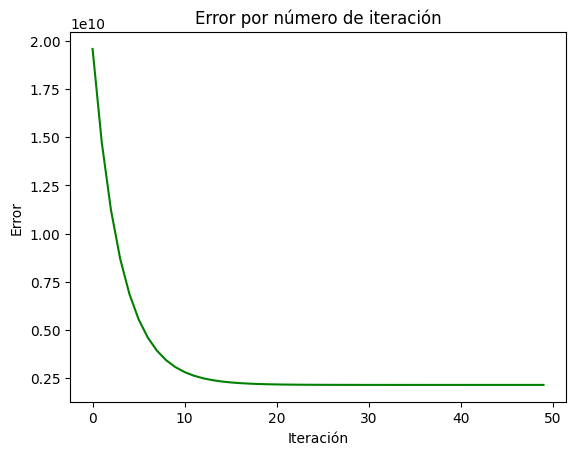

In [193]:
graficaError(index,error)

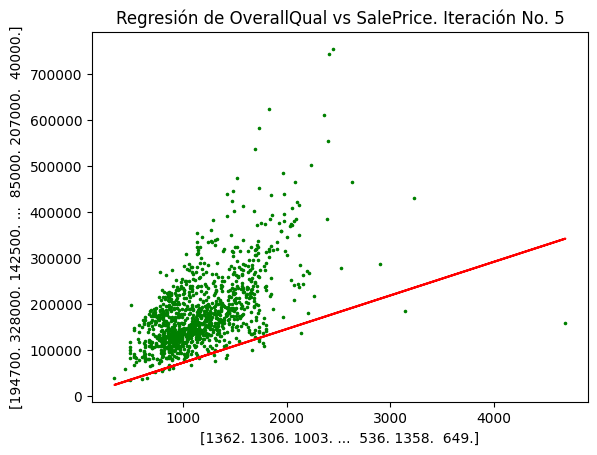

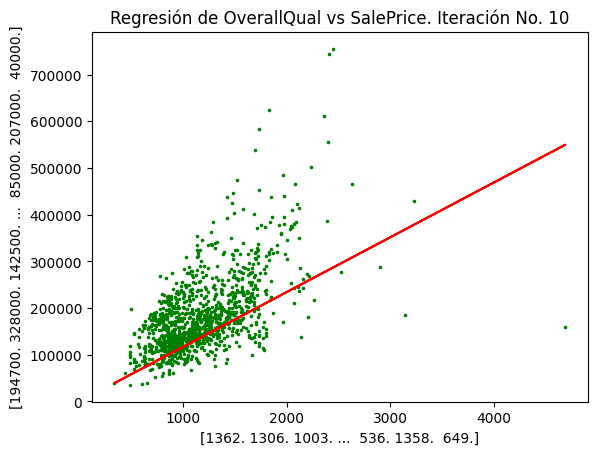

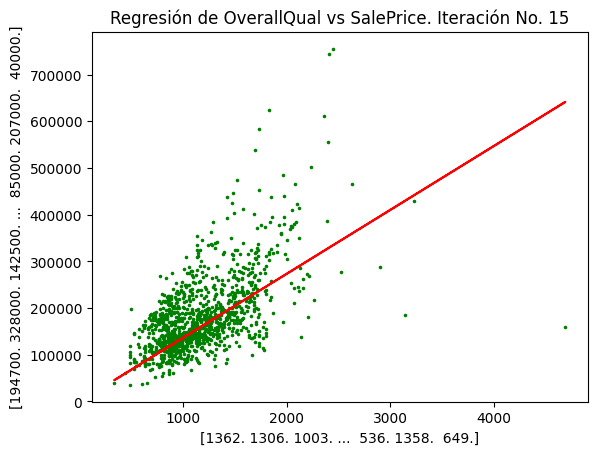

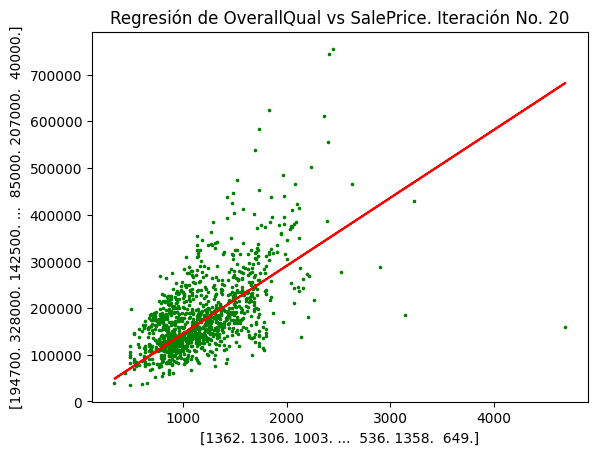

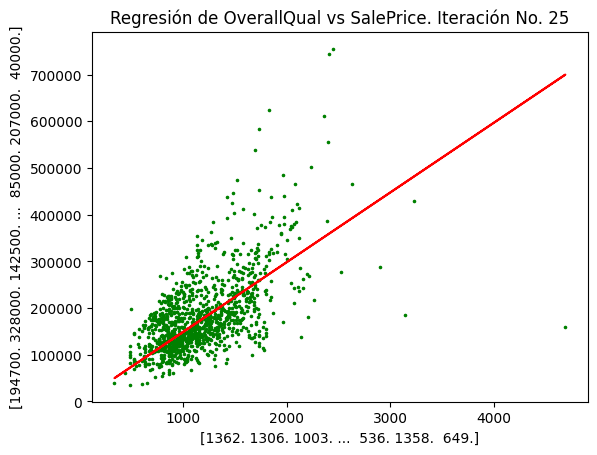

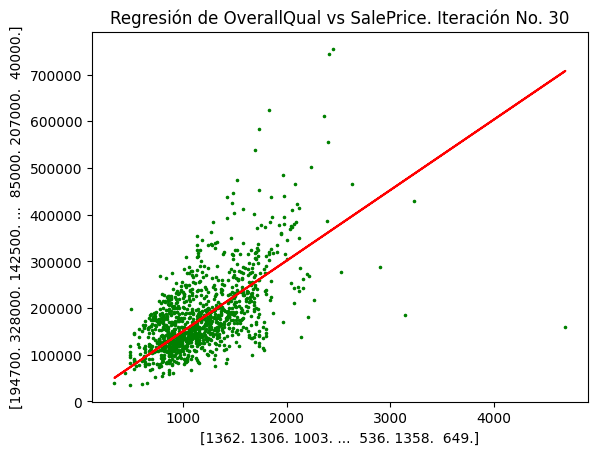

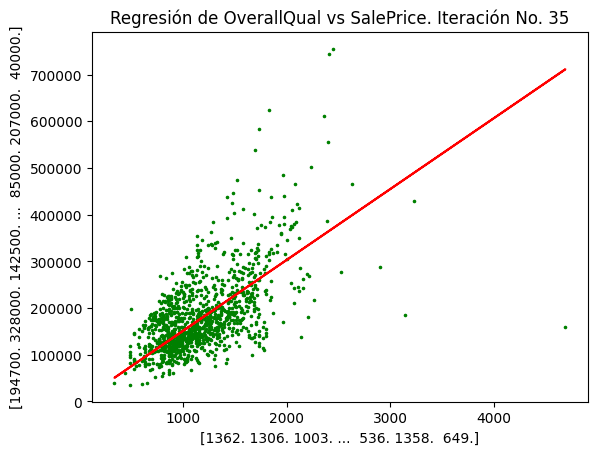

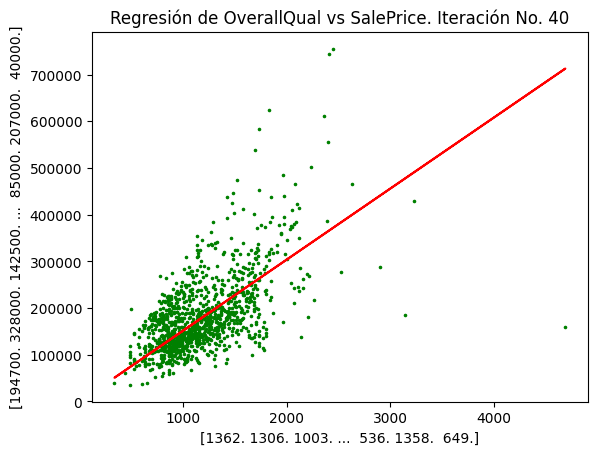

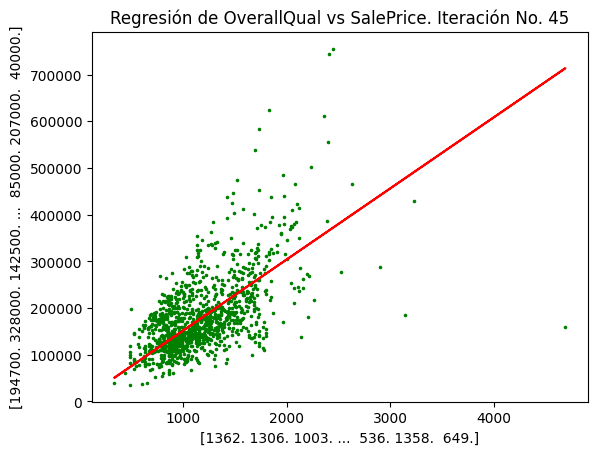

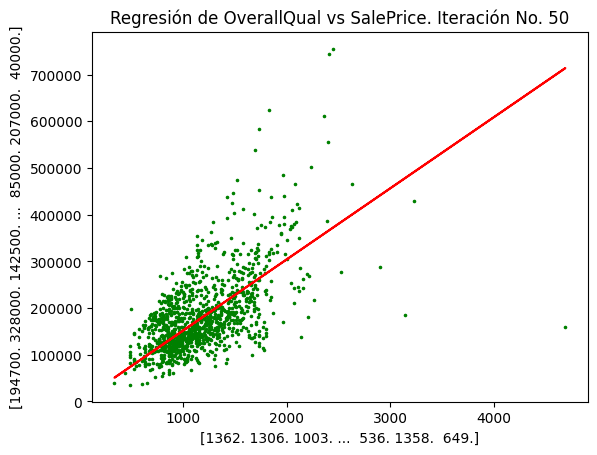

In [197]:
graficarModelo(df_entre['1stFlrSF'].values, df_entre['SalePrice'].values, yPrima, 5)